# This addresses both Issues 212 and 213

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pysm3.units as u
from pysm3.models.cmb import CMBMap
from pysm3.models.cmb import CMBLensed as CMBLensedOriginal

# Issues

## Issue 212

CAMB output power spectra include the monopole and dipole ($\ell=0$ and $\ell=1$), but the `c1` power spectra do not:

In [2]:
ps_camb = "demo_powerspectra/camb_ps.dat"  # Only used to demonstrate that CAMB output includes L=0,1
ps_c1 = "demo_powerspectra/c1_ps.dat"

print("CAMB output power spectra:")
with open(ps_camb, "r") as f:
    for i in range(6):
        print(' '*5, f.readline().rstrip())

print("Original c1 power spectra:")
with open(ps_c1, "r") as f:
    for i in range(4):
        print(' '*5, f.readline().rstrip())

CAMB output power spectra:
      #  L TT            EE            BB            TE            PP            PT            PE
         0 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
         1 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
         2 1.0825953e+03 1.4746664e-01 1.4796820e-07 6.6772338e+00 5.2118790e-08 2.7735919e-03 -2.5091173e-05
         3 1.0465663e+03 3.9779316e-01 2.9968791e-07 1.0461787e+01 6.2924300e-08 2.8439773e-03 -3.7494399e-05
         4 9.9860773e+02 7.4959835e-01 5.0778217e-07 1.3168715e+01 7.2089927e-08 2.8437573e-03 -4.7767740e-05
Original c1 power spectra:
      #    L    TT             EE             BB             TE             PP             TP             EP
           2    0.10678E+04    0.34282E-01    0.00000E+00    0.27104E+01    0.49277E-07    0.32326E-02   -0.12847E-04
           3    0.10029E+04    0.46186E-01    0.00000E+00    0.31328E+01 

I've manually added two lines to a modified version of the `c1` power spectra file (for use with this example):

In [3]:
ps_c1_with_l01 = "demo_powerspectra/c1_ps_l01.dat"

print("Modified c1 power spectra, to be used for demonstration in the notebook:")
with open(ps_c1_with_l01, "r") as f:
    for i in range(6):
        print(' '*5, f.readline().rstrip())

Modified c1 power spectra, to be used for demonstration in the notebook:
      #    L    TT             EE             BB             TE             PP             TP             EP
           0    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00
           1    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00    0.00000E+00
           2    0.10678E+04    0.34282E-01    0.00000E+00    0.27104E+01    0.49277E-07    0.32326E-02   -0.12847E-04
           3    0.10029E+04    0.46186E-01    0.00000E+00    0.31328E+01    0.60013E-07    0.32173E-02   -0.14138E-04
           4    0.94274E+03    0.42475E-01    0.00000E+00    0.30100E+01    0.69182E-07    0.31297E-02   -0.12452E-04


When I use `CMBLensed` with the original `c1` spectra, the output differs from when I use it with the modified `c1` spectra.

### Comparing maps

In [4]:
def compare_maps(cmbl1, cmbl2,
                 label1, label2):
    m1 = cmbl1.map
    m2 = cmbl2.map
    fig, axs = plt.subplots(3, 3, figsize=(12, 8))
    plt.sca(axs[0,0])
    hp.mollview(m2[0], title=f"{label1} T", hold=True)
    plt.sca(axs[0,1])
    hp.mollview(m2[1], title=f"{label1} Q", hold=True)
    plt.sca(axs[0,2])
    hp.mollview(m2[2], title=f"{label1} U", hold=True)
    plt.sca(axs[1,0])
    hp.mollview(m1[0], title=f"{label2} T", hold=True)
    plt.sca(axs[1,1])
    hp.mollview(m1[1], title=f"{label2} Q", hold=True)
    plt.sca(axs[1,2])
    hp.mollview(m1[2], title=f"{label2} U", hold=True)
    plt.sca(axs[2,0])
    hp.mollview(m1[0] - m2[0], title="Delta T", hold=True)
    plt.sca(axs[2,1])
    hp.mollview(m1[1] - m2[1], title="Delta Q", hold=True)
    plt.sca(axs[2,2])
    hp.mollview(m1[2] - m2[2], title="Delta U", hold=True)
    plt.show()

This affects the maps output:

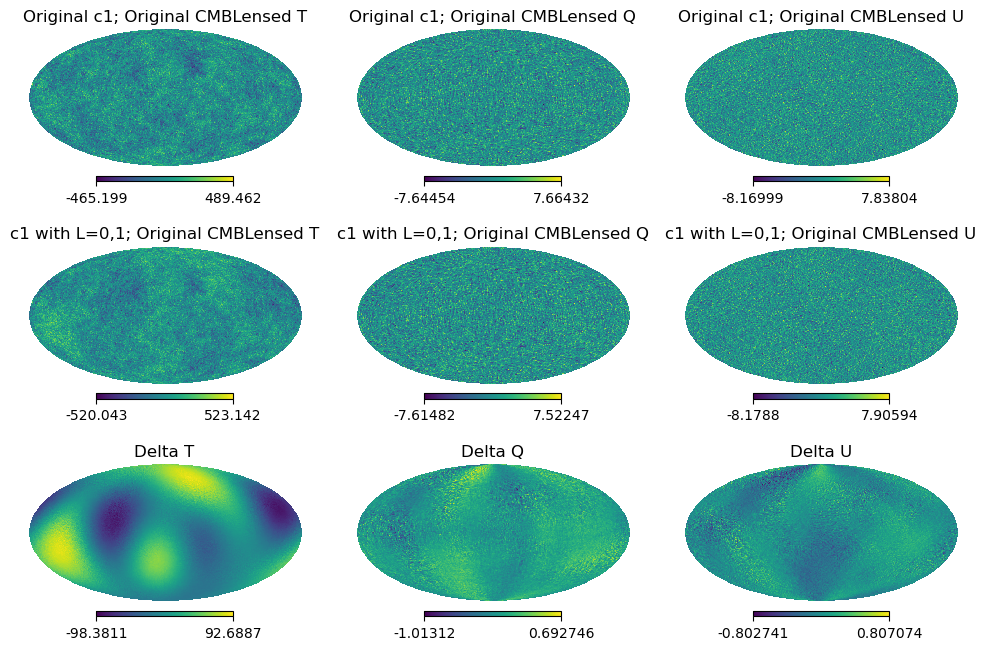

In [5]:
params = dict(
    nside=128,
    # max_nside=None,
    cmb_seed=0,
    # apply_delens=False,
    # delensing_ells=None,
    # map_dist=None,
)
cmbl1 = CMBLensedOriginal(cmb_spectra=ps_c1, **params)
cmbl2 = CMBLensedOriginal(cmb_spectra=ps_c1_with_l01, **params)
compare_maps(cmbl1=cmbl1, cmbl2=cmbl2,
             label1="Original c1; Original CMBLensed", 
             label2="c1 with L=0,1; Original CMBLensed")

## Issue 213

When running CMBLensed with `apply_delens=True`, there is a ValueError.

In [6]:
try:
    will_crash = CMBLensedOriginal(
        nside=128,
        cmb_spectra="demo_powerspectra/c1_ps_l01.dat",
        # max_nside=None,
        # cmb_seed=0,
        apply_delens=True,
        delensing_ells="demo_powerspectra/c1_delensing_ells.dat",
        # map_dist=None,
    )
except ValueError as e:
    print(e)

operands could not be broadcast together with shapes (2201,) (2,) 


## Combined Issues

The issues compound. The `delensing_ells` are also expected to be missing the monopole and dipole.

In [7]:
delensing_ells_fp = "demo_powerspectra/c1_delensing_ells.dat"

print("Delensing ells:")
with open(delensing_ells_fp, "r") as f:
    for i in range(6):
        print(' '*5, f.readline().rstrip())

Delensing ells:
      2.000000000000000000e+00 1.000000000000000000e+00
      3.000000000000000000e+00 1.000000000000000000e+00
      4.000000000000000000e+00 1.000000000000000000e+00
      5.000000000000000000e+00 1.000000000000000000e+00
      6.000000000000000000e+00 1.000000000000000000e+00
      7.000000000000000000e+00 1.000000000000000000e+00


# Resolution

The issues compound: changes to the `__init__` method of `CMBLensed` can account for both of these issues (lines 46-57):

In [8]:
# Revised, minimal changes to the __init__ method are all that is needed

class CMBLensedRevised(CMBMap):
    # intherit from CMBMap so we get the `get_emission` method
    def __init__(
        self,
        nside,
        cmb_spectra,
        max_nside=None,
        cmb_seed=None,
        apply_delens=False,
        delensing_ells=None,
        map_dist=None,
    ):
        """Lensed CMB

        Takes an input unlensed CMB and lensing spectrum from CAMB and uses
        Taylens to apply lensing, it optionally simulates delensing by
        suppressing the lensing power at specific scales with the user
        provided `delensing_ells`.

        Parameters
        ----------

        cmb_spectra : path
            Input text file from CAMB, spectra unlensed
        cmb_seed : int
            Numpy random seed for synfast, set to None for a random seed
        apply_delens : bool
            If true, simulate delensing with taylens
        delensing_ells : path
            Space delimited file with ells in the first columns and suppression
            factor (1 for no suppression) in the second column
        """
        try:
            super().__init__(nside=nside, max_nside=max_nside, map_dist=map_dist)
        except ValueError:
            pass  # suppress exception about not providing any input map
        self.cmb_spectra = self.read_txt(cmb_spectra, unpack=True)
        self.cmb_seed = cmb_seed
        self.apply_delens = apply_delens
        self.delensing_ells = (
            None if delensing_ells is None else self.read_txt(delensing_ells, unpack=True)
        )

        # Remove monopole and dipole, if present
        if self.cmb_spectra[0][0] == 0:
            self.cmb_spectra = self.cmb_spectra[:, 2:]
        if self.apply_delens and self.delensing_ells[0][0] == 0:
            self.delensing_ells = self.delensing_ells[:, 2:]

        self.map = u.Quantity(self.run_taylens(), unit=u.uK_CMB, copy=False)


    def run_taylens(self):
        pass

CMBLensedRevised.run_taylens = CMBLensedOriginal.run_taylens

## Addressing 212

The change handles the presence of monopole and dipole.

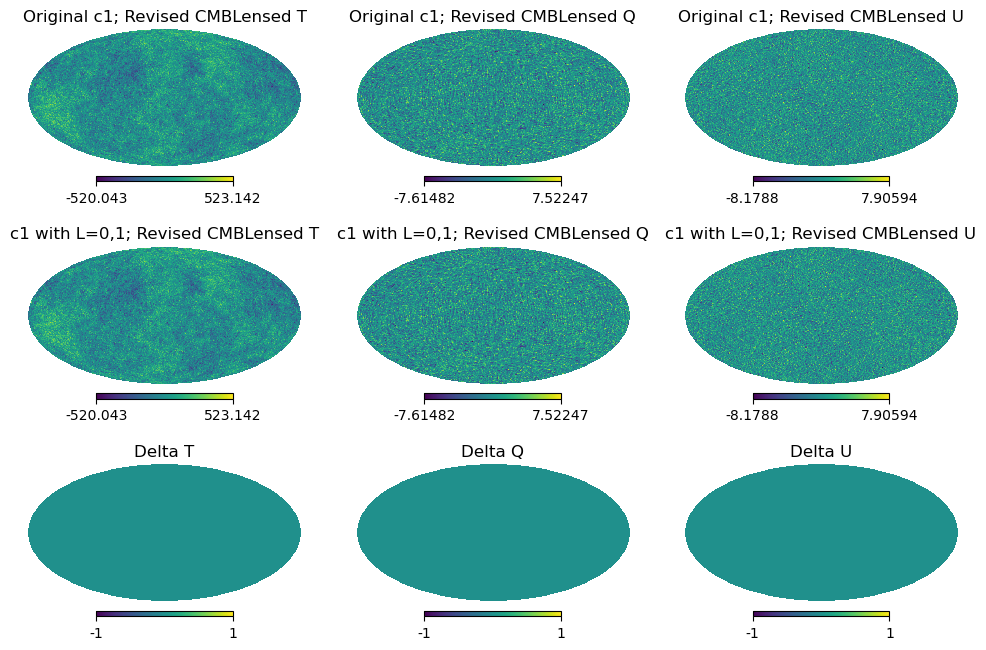

In [9]:
params = dict(
    nside=128,
    # max_nside=None,
    cmb_seed=0,
    # apply_delens=False,
    # delensing_ells=None,
    # map_dist=None,
)
cmbl1 = CMBLensedRevised(cmb_spectra=ps_c1, **params)
cmbl2 = CMBLensedRevised(cmb_spectra=ps_c1_with_l01, **params)
compare_maps(cmbl1=cmbl1, cmbl2=cmbl2,
             label1="Original c1; Revised CMBLensed", 
             label2="c1 with L=0,1; Revised CMBLensed")

### `RevisedCMBLensed` doesn't change expected results

The results are the **same** for the original `c1` input:

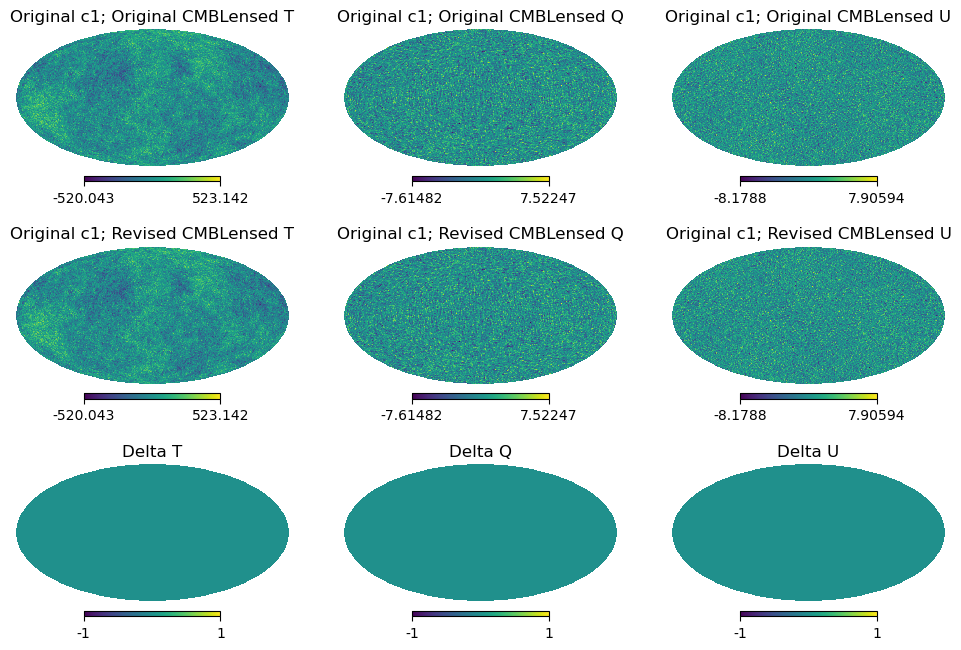

In [10]:
params = dict(
    nside=128,
    # max_nside=None,
    cmb_seed=0,
    # apply_delens=False,
    # delensing_ells=None,
    # map_dist=None,
)
cmbl1 = CMBLensedOriginal(cmb_spectra=ps_c1, **params)
cmbl2 = CMBLensedRevised(cmb_spectra=ps_c1, **params)
compare_maps(cmbl1=cmbl1, cmbl2=cmbl2,
             label1="Original c1; Original CMBLensed", 
             label2="Original c1; Revised CMBLensed")

More information on why the error occurs is in [this other notebook](issue_212_demo.ipynb).

## Addressing Issue 213

In [11]:
try:
    will_run = CMBLensedRevised(
        nside=128,
        cmb_spectra="demo_powerspectra/c1_ps.dat",
        # max_nside=None,
        # cmb_seed=0,
        apply_delens=True,
        delensing_ells="demo_powerspectra/c1_delensing_ells.dat",
        # map_dist=None,
    )
    print("Successful run.")
except ValueError as e:
    print(e)

Successful run.


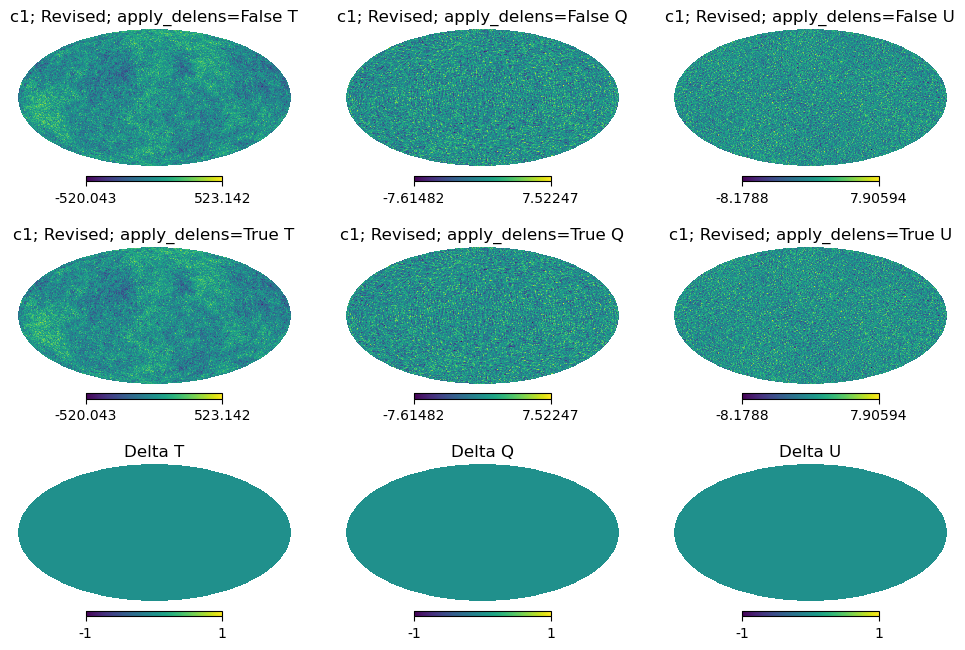

In [12]:
params = dict(
    nside=128,
    # max_nside=None,
    cmb_seed=0,
    # apply_delens=False,
    delensing_ells="demo_powerspectra/c1_delensing_ells.dat",
    # map_dist=None,
)
cmbl1 = CMBLensedRevised(cmb_spectra=ps_c1, 
                         apply_delens=False,
                         **params)
cmbl2 = CMBLensedRevised(cmb_spectra=ps_c1, 
                         apply_delens=True,
                         **params)
compare_maps(cmbl1=cmbl1, cmbl2=cmbl2,
                label1="c1; Revised; apply_delens=False", 
                label2="c1; Revised; apply_delens=True")

To check that delensing does *something*, the `delensing_ells` can be changed. This is a trivial example; I don't know what typical good values would be.

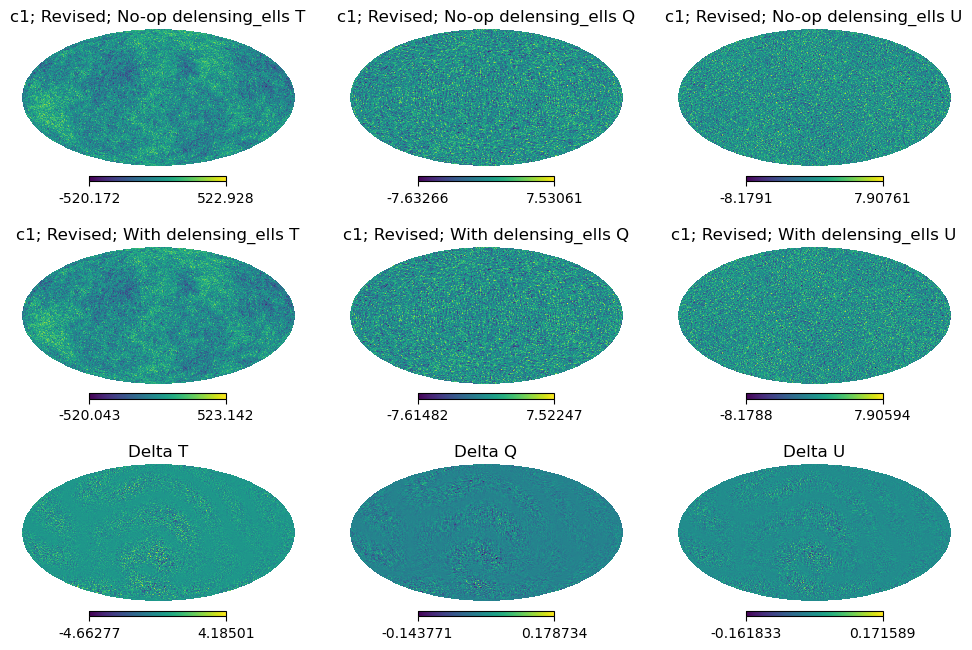

In [13]:
params = dict(
    nside=128,
    # max_nside=None,
    cmb_seed=0,
    apply_delens=True,
    delensing_ells="demo_powerspectra/c1_delensing_ells.dat",
    # map_dist=None,
)
cmbl1 = CMBLensedRevised(cmb_spectra=ps_c1, 
                         **params)
cmbl2 = CMBLensedRevised(cmb_spectra=ps_c1, 
                         **params)
cmbl2.delensing_ells[1, 2:4] = 0.5
cmbl2.map = u.Quantity(cmbl2.run_taylens(), unit=u.uK_CMB, copy=False)
compare_maps(cmbl1=cmbl1, cmbl2=cmbl2,
             label1="c1; Revised; No-op delensing_ells", 
             label2="c1; Revised; With delensing_ells")

# Showing it resolves combined issues

Showing that more than the two solutions individually are needed is a bit... odd.

It should be apparent by inspection that if additional monopoles in delensing ells aren't handled, there will be issues. That's the reason behind the first extra change:

```python
        if self.apply_delens and self.delensing_ells[0][0] == 0:
            self.delensing_ells = self.delensing_ells[:, 2:]
```

Truncating won't matter; the monopole and dipole are not expected to be handled.

To show this, instead of providing just one fix or the other, it's simpler to just use the `CMBLensedRevised` method, but reload the delensing ells to force the mismatch. This illustrates the errors that wouldn't occur without the changes.

In [14]:
params = dict(
    nside=128,
    # max_nside=None,
    cmb_seed=0,
    apply_delens=True,
    # delensing_ells=None,
    # map_dist=None,
)
cmbl = CMBLensedRevised(cmb_spectra=ps_c1, 
                         delensing_ells="demo_powerspectra/c1_delensing_ells_l01.dat",
                         **params)

# reload without removing monopole and dipole
cmbl.delensing_ells = cmbl.read_txt("demo_powerspectra/c1_delensing_ells_l01.dat", unpack=True)
try:
    cmbl.map = u.Quantity(cmbl.run_taylens(), unit=u.uK_CMB, copy=False)
except ValueError as e:
    print(e)

operands could not be broadcast together with shapes (2199,) (2201,) 


In [15]:
params = dict(
    nside=128,
    # max_nside=None,
    cmb_seed=0,
    apply_delens=True,
    # delensing_ells=None,
    # map_dist=None,
)
cmbl = CMBLensedRevised(cmb_spectra=ps_c1_with_l01,
                         delensing_ells="demo_powerspectra/c1_delensing_ells_l01.dat",
                         **params)

# reload without removing monopole and dipole
cmbl.cmb_spectra = cmbl.read_txt(ps_c1_with_l01, unpack=True)
try:
    cmbl.map = u.Quantity(cmbl.run_taylens(), unit=u.uK_CMB, copy=False)
except ValueError as e:
    print(e)

operands could not be broadcast together with shapes (2201,) (2199,) 
